In [ ]:
!pip install gensim textblob

In [ ]:
import pandas as pd
import nltk
#import gensim
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
#from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

analyzer = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#pre-processing reviews
def tokenize_text(text):
    text = str(text).lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens
                  if token.isalpha() and token not in stop_words]
    return lemmatized

def join_tokens(text):
    return ' '.join(text)

#lexicon based sentiment analysis
def sentiment_analysis(df,col_name):
    df_textblob = pd.DataFrame()
    df_vader = pd.DataFrame()

    df_textblob['index'] = df['index']  # Retain original index
    df_vader['index'] = df['index']

    # TextBlob sentiment
    df_textblob['sentiment_score'] = df[col_name].apply(lambda x: TextBlob(x).sentiment.polarity)
    df_textblob['sentiment_label'] = df_textblob['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.4 else 'negative' if x < -0.4 else 'neutral')

    # VADER sentiment
    df_vader['sentiment_score'] = df[col_name].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df_vader['sentiment_label'] = df_vader['sentiment_score'].apply(
        lambda x: 'positive' if x > 0.04 else 'negative' if x < -0.04 else 'neutral')

    # Merge on original index and sentiment_label
    merged_df = pd.merge(df_textblob, df_vader, on=['index', 'sentiment_label'], how='inner')
    merged_df = merged_df.set_index('index')  # Restore original index

    # Filter original df based on index
    filtered_df = df.set_index('index').loc[merged_df.index].copy()
    filtered_df['sentiment_label'] = merged_df['sentiment_label']
    filtered_df['TB_SCORE'] = merged_df['sentiment_score_x']
    filtered_df['VADER_SCORE'] = merged_df['sentiment_score_y']

    return filtered_df


In [ ]:
from itertools import count
#aspect based sentiment analysis
def aspect_sentiment_analysis(df, aspects, col_name):
    results = []

    for aspect in aspects:
        # Find reviews mentioning the aspect
        aspect_reviews = df[df[col_name].str.contains(aspect, case=False, regex=True)]

        if len(aspect_reviews) > 0:
            # Calculate sentiment for these reviews
            output= sentiment_analysis(aspect_reviews,col_name)
            sentiments = output['sentiment_label']
            pred_txb = output['TB_SCORE']
            pred_vader = output['VADER_SCORE']

            # Map sentiment labels to numeric scores
            sentiment_numeric = sentiments.map({'positive': 1, 'neutral': 0, 'negative': -1})

            # Aggregate results
            stats = {
                'aspect': aspect,
                'mention_count': len(aspect_reviews),
                #'avg_act_sentiment': aspect_reviews['sentiment'].mean() * 100,
                'avg_pred_sentiment': sentiment_numeric.mean()*100,
                #'avg_snt_txb': pred_txb.mean() * 100,
                #'avg_snt_vader': pred_vader.mean() * 100,
                'positive_pct': (sentiments == 'positive').mean() * 100,
                'negative_pct': (sentiments == 'negative').mean() * 100,
                'neutral_pct': (sentiments == 'neutral').mean() * 100
            }
            results.append(stats)

    aspect_results=pd.DataFrame(results)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='aspect', y='avg_pred_sentiment', data=aspect_results.sort_values('avg_pred_sentiment'))
    return print(aspect_results)

In [ ]:
# n-gram analysis
def n_gram(df,col_name,n_token,words_to_remove):
  df_ngram=pd.DataFrame()
  df_ngram['processed_text'] = df[col_name].apply(tokenize_text).apply(join_tokens)

  stop_words = set(stopwords.words('english')).union(set(words_to_remove))

  vectorizer = CountVectorizer(
    stop_words=list(stop_words) ,
    token_pattern=r'(?u)\b\w\w+\b',
    ngram_range=(n_token,n_token),
    max_df=0.99,
    min_df=2
  )
  X = vectorizer.fit_transform(df_ngram['processed_text'])

  ngrams = vectorizer.get_feature_names_out()
  ngrams_freq = pd.DataFrame(X.toarray(), columns=ngrams).sum().sort_values(ascending=False)
  top_ngrams = ngrams_freq.head(20)

  # Post-processing to filter similar n-grams
  unique_ngrams = []
  seen_lemmas = set()

  for ngrams in top_ngrams.index:
      # Get unique lemmas
      ngrams_lemmas = frozenset([lemmatizer.lemmatize(word) for word in ngrams.split()])

      # Only keep if we haven't seen this combination before
      if ngrams_lemmas not in seen_lemmas:
          unique_ngrams.append(ngrams)
          seen_lemmas.add(ngrams_lemmas)
      if len(unique_ngrams) >= 10:
          break

  final_ngrams = top_ngrams[unique_ngrams]

  # Visualization
  plt.figure(figsize=(12, 8))
  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')
  plt.xlabel("Frequency")
  return print(final_ngrams)


In [ ]:
#aspect based clustering
def clustering_review(df,col_name,n_clusters,aspects):
  aspect_sentences = {}
  for aspect in aspects:
    subset = df[df[col_name].str.contains(aspect, case=False, na=False)]
    aspect_sentences[aspect] = [tokenize_text(text) for text in subset[col_name]]


  for aspect, sentences in aspect_sentences.items():
    print(f"\n=== Aspect: {aspect} ===")
    if len(sentences) < 5:
        print("Not enough data.")
        continue

    model = Word2Vec(sentences, vector_size=100, window=5, min_count=100, workers=4)

    words = list(model.wv.index_to_key)
    vectors = np.array([model.wv[word] for word in words])

    if len(words) < 5:
        print("Not enough unique words to cluster.")
        continue

    n = min(n_clusters, len(words))  # avoid asking for more clusters than words
    kmeans = KMeans(n_clusters=n, random_state=0)
    clusters = kmeans.fit_predict(vectors)
    centroids = kmeans.cluster_centers_

    word_df = pd.DataFrame(vectors, index=words)
    word_df['cluster'] = clusters

    top_words = {}
    for i in range(n_clusters):
        cluster_words = word_df[word_df['cluster'] == i].drop('cluster', axis=1)
        dists = np.linalg.norm(cluster_words.values - centroids[i], axis=1)
        closest_indices = dists.argsort()[:5]
        top_words[i] = cluster_words.iloc[closest_indices].index.tolist()

    for cluster_id, words in top_words.items():
        print(f"Cluster {cluster_id}: {words}")


In [ ]:
def generate_aspect_wordclouds(df, aspects, col_name):
    for aspect in aspects:
        # Filter reviews containing the aspect
        aspect_reviews = df[df[col_name].str.contains(aspect, case=False, regex=True)]

        if not aspect_reviews.empty:
            # Apply tokenize_text to each review, then flatten the list of tokens
            all_tokens = []
            for review in aspect_reviews[col_name].dropna().astype(str):
                tokens = tokenize_text(review)
                all_tokens.extend(tokens)

            # Join tokens into a single string
            text = " ".join(all_tokens)

            # Generate word cloud
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

            # Display
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"Word Cloud for Aspect: '{aspect}'", fontsize=16)
            plt.show()


In [ ]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/disham993/ElectricalDeviceFeedbackBalanced/" + splits["train"])

In [ ]:
df.head()
df.to_csv("d3.csv")

/tmp/ipython-input-3520228773.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_ngrams.values, y=final_ngrams.index, palette='viridis')


smart meter             6606
circuit breaker         3089
solar panel              957
electrical panel         788
mobile app               693
user interface           558
customer support         509
approximately hour       500
identify area            486
approximately minute     480
dtype: int64


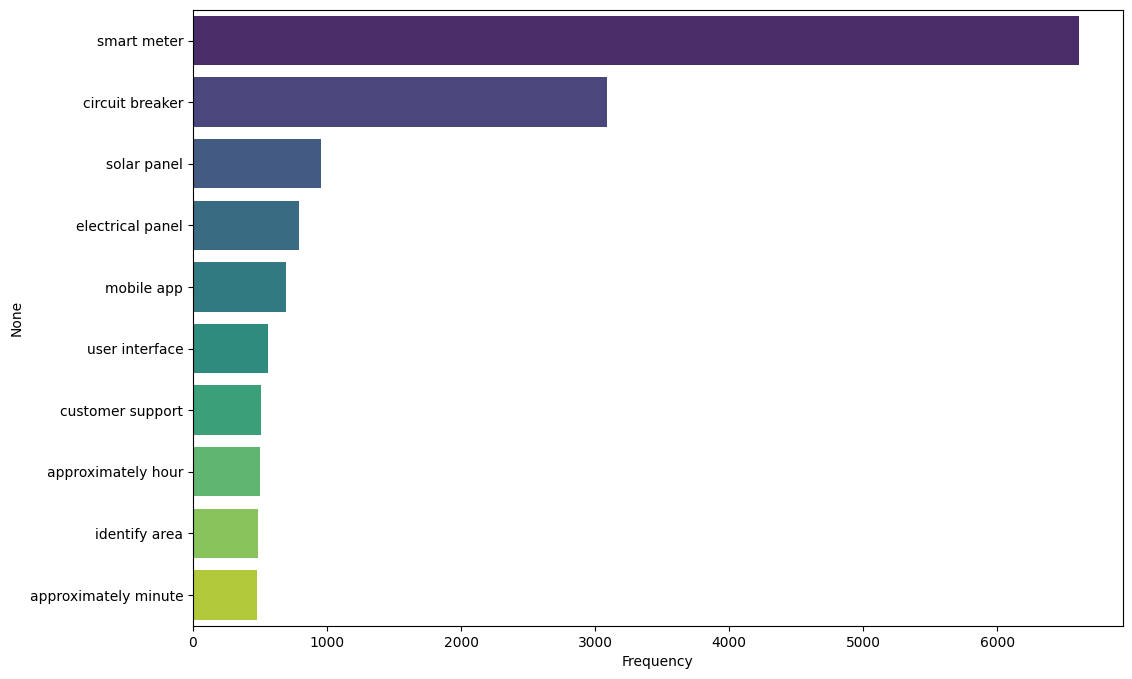

In [ ]:
top_words= n_gram(df,'text',2,['abc','installed','six','month','new','energy','consumption','took','plus','side','however','noticed','complete','bill',
                               'approximaely','installation','operates','within','home','required','utility','company','usage'])

In [ ]:
clusters= clustering_review(df,'text',3,['smart meter','circuit breaker', 'solar panel', 'customer Support'] )


=== Aspect: smart meter ===
Cluster 0: ['seem', 'furthermore', 'instance', 'several', 'concerned']
Cluster 1: ['great', 'see', 'analytics', 'keep', 'allows']
Cluster 2: ['calibrated', 'capacity', 'local', 'memory', 'second']

=== Aspect: circuit breaker ===
Cluster 0: ['really', 'installation', 'using', 'positive', 'panel']
Cluster 1: ['outage', 'hand', 'occasional', 'work', 'sensitivity']
Cluster 2: ['transformer', 'rating', 'resulting', 'thermal', 'response']

=== Aspect: solar panel ===
Cluster 0: ['however', 'consumption', 'smart', 'six', 'issue']
Cluster 1: ['efficiency', 'within', 'monitoring', 'peak', 'range']
Cluster 2: ['roof', 'grid', 'rooftop', 'overall', 'march']

=== Aspect: customer Support ===
Cluster 0: ['issue', 'installed', 'usage', 'consumption', 'home']
Cluster 1: ['customer', 'support', 'meter', 'however', 'energy']
Cluster 2: ['time', 'recently', 'new', 'installation', 'month']


In [ ]:
df=df.reset_index(drop=False)
df

,index,text,label
0,0,The incorporation of non-linear magneto-electr...,0
1,1,I recently installed a new smart meter in my h...,0
2,2,The circuit breaker's thermal-magnetic trip me...,0
3,3,The new smart meter installed at my house has ...,0
4,4,I've been using the 15A 6-outlet power strip f...,2
...,...,...,...
11547,11547,* Demonstrating realistic technical observatio...,2
11548,11548,I'm extremely disappointed with the performanc...,0
11549,11549,The inverter's energy monitoring feature is us...,1
11550,11550,The circuit breaker has exceeded its lifespan ...,0


             aspect  mention_count  avg_pred_sentiment  positive_pct  \
0       smart meter           6259           71.317829     71.317829   
1   circuit breaker           3008           24.634656     31.106472   
2       solar panel            941           38.372093     41.860465   
3  customer Support            508           72.727273     72.727273   

   negative_pct  neutral_pct  
0      0.000000    28.682171  
1      6.471816    62.421712  
2      3.488372    54.651163  
3      0.000000    27.272727  


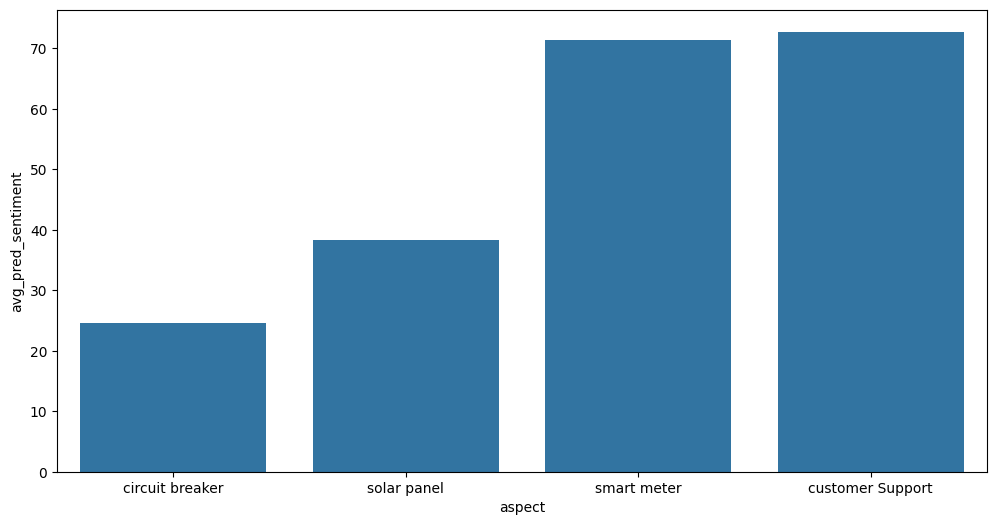

In [ ]:
sentiment= aspect_sentiment_analysis(df,['smart meter','circuit breaker', 'solar panel', 'customer Support'],'text')

In [ ]:
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def analyze_reviews(df, text_column, aspects):
    """
    Find most relevant words around your aspects WITHOUT clustering

    Args:
        df: Your DataFrame
        text_column: Name of text column
        aspects: List of focus words (e.g., ['price', 'quality'])

    Returns:
        Dictionary of {aspect: [top 10 related words]}
    """
    results = {}
    stop_words = set(stopwords.words('english'))

    for aspect in aspects:
        aspect_words = []

        for text in df[text_column].dropna().str.lower():
            words = nltk.word_tokenize(text)

            if aspect in words:
                idx = words.index(aspect)
                start = max(0, idx-5)  # 3 words before
                end = min(len(words), idx+4)  # 3 words after
                context = words[start:end]

                # Filter out junk
                clean_words = [
                    w for w in context
                    if w not in stop_words
                    and w.isalpha()
                    and w != aspect
                ]
                aspect_words.extend(clean_words)

        # Get most common words
        top_words = [word for word, count in Counter(aspect_words).most_common(10)]
        results[aspect] = top_words

    return results

# Usage:
aspects = ['smart' ,'meter','circuit', 'breaker', 'solar','panel', 'customer', 'Support']
word_groups = analyze_reviews(df, 'text', aspects)
word_groups

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'smart': ['meter',
  'installed',
  'new',
  'recently',
  'using',
  'grid',
  'newly',
  'energy',
  'purchased',
  'system'],
 'meter': ['smart',
  'installed',
  'new',
  'home',
  'six',
  'recently',
  'using',
  'energy',
  'months',
  'purchased'],
 'circuit': ['breaker',
  'installed',
  'new',
  'tripping',
  'arc',
  'main',
  'breakers',
  'using',
  'smart',
  'purchased'],
 'breaker': ['circuit',
  'installed',
  'new',
  'tripping',
  'home',
  'arc',
  'main',
  'purchased',
  'fault',
  'smart'],
 'solar': ['panel',
  'system',
  'array',
  'inverter',
  'installed',
  'home',
  'panels',
  'new',
  'efficiency',
  'energy'],
 'panel': ['solar',
  'electrical',
  'system',
  'main',
  'installed',
  'home',
  'array',
  'existing',
  'connected',
  'breaker'],
 'customer': ['support',
  'team',
  'service',
  'however',
  'smooth',
  'installed',
  'process',
  'multiple',
  'additionally',
  'meter'],
 'Support': []}

In [ ]:
aspects = ['smart' ,'meter','circuit', 'breaker', 'solar','panel', 'customer', 'Support']
word_groups = analyze_reviews(df, 'text', aspects)
for key, value in word_groups.items():
    print(f"{{{key!r}: {value}}}")

{'smart': ['meter', 'installed', 'new', 'recently', 'using', 'grid', 'newly', 'energy', 'purchased', 'system']}
{'meter': ['smart', 'installed', 'new', 'home', 'six', 'recently', 'using', 'energy', 'months', 'purchased']}
{'circuit': ['breaker', 'installed', 'new', 'tripping', 'arc', 'main', 'breakers', 'using', 'smart', 'purchased']}
{'breaker': ['circuit', 'installed', 'new', 'tripping', 'home', 'arc', 'main', 'purchased', 'fault', 'smart']}
{'solar': ['panel', 'system', 'array', 'inverter', 'installed', 'home', 'panels', 'new', 'efficiency', 'energy']}
{'panel': ['solar', 'electrical', 'system', 'main', 'installed', 'home', 'array', 'existing', 'connected', 'breaker']}
{'customer': ['support', 'team', 'service', 'however', 'smooth', 'installed', 'process', 'multiple', 'additionally', 'meter']}
{'Support': []}


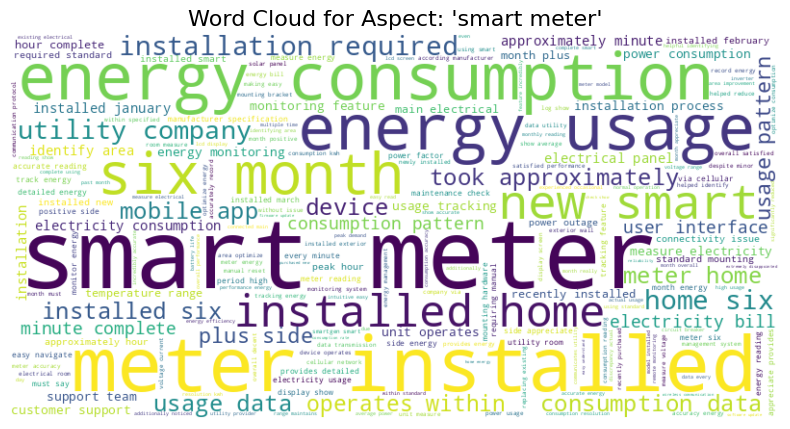

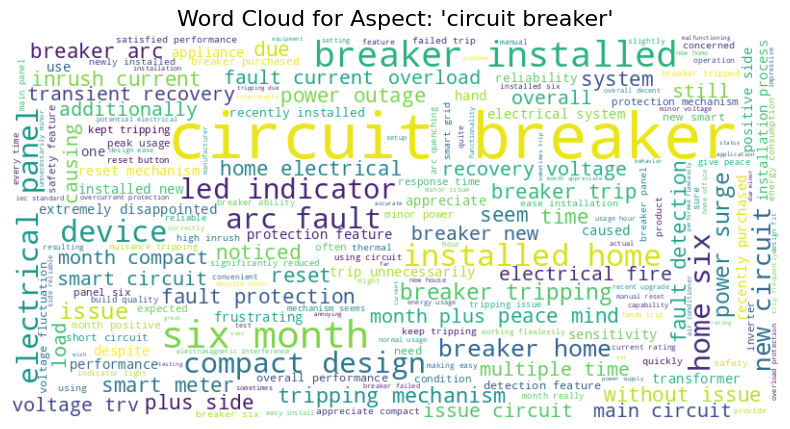

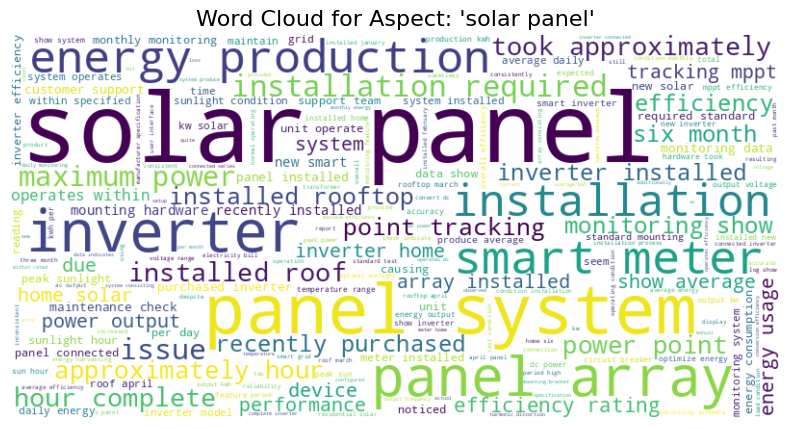

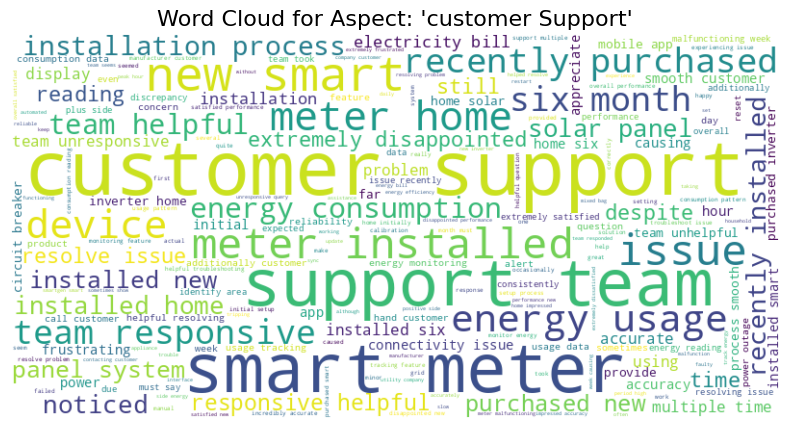

In [ ]:

generate_aspect_wordclouds(df, ['smart meter','circuit breaker', 'solar panel', 'customer Support'], 'text')

In [ ]:
output=sentiment_analysis(df,'text')
output
output.to_csv("d3.csv")